In [98]:
import json
import numpy as np
import os
import pandas as pd
import urllib3
import urllib.request
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU, PReLU
from keras.utils import np_utils
from keras.callbacks import CSVLogger, ModelCheckpoint
import h5py
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

In [99]:
#coins = ['BTC', 'LTC', 'ETH', 'XRP']
coins = ['XRP']

In [100]:
# ratio of train to test split (originally at 0.8)
train_ratio = 0.9

In [101]:
from datetime import datetime, timedelta
from time import mktime

delta_days = 90

t = datetime.now()
end_tm = np.int(mktime(t.timetuple()))
tpast = t - timedelta(days=delta_days)
start_tm = np.int(mktime(tpast.timetuple()))
#start_tm = mktime((t - timedelta(days=delta_days)).tuple())
period_step = 300

In [102]:
df_list=[]

container = []

for coin in coins:
    url = 'https://poloniex.com/public?command=returnChartData&currencyPair=USDT_'+coin+'&start={0}&end={1}&period={2}'.format(start_tm, end_tm, period_step)
    openUrl = urllib.request.urlopen(url)
    r = openUrl.read()
    openUrl.close()
    d = json.loads(r.decode())
    dfx = pd.DataFrame(d)
    dfx['coin'] = coin
    container.append(dfx)
    print(pd.DataFrame(d).shape)
    
container = pd.concat(container, axis = 0)
print('Returned length of {0} coins: {1}'.format(len(coins), container.shape))


# format
original_columns=[u'close', u'date', u'high', u'low', u'open']
new_columns = ['Close','Timestamp','High','Low','Open']
container = container.loc[:,original_columns]
container.columns = new_columns
container.to_csv('data/bitcoin2015to2017.csv',index=None)

# export out
h5path = 'data/4coins_17apr2021.h5'
container.to_hdf(h5path, key='df', mode='w')
#container.to_csv('data/4coins_17apr2021.csv',index=None)

(25921, 8)
Returned length of 1 coins: (25921, 9)


In [103]:
# validate returns
container.head()

,Close,Timestamp,High,Low,Open
0,0.273383,1610871513,0.273383,0.273383,0.273383
1,0.272726,1610871600,0.273198,0.272566,0.273174
2,0.273000,1610871900,0.273195,0.272542,0.272600
3,0.274085,1610872200,0.274085,0.273197,0.273666
4,0.273293,1610872500,0.273563,0.273293,0.273563


In [136]:
len(container)

25921

In [131]:

import numpy as np
import pandas as pd
 
class PastSampler:
    '''
    Forms training samples for predicting future values from past value
    '''
     
    def __init__(self, N, K, sliding_window = True):
        '''
        Predict K future sample using N previous samples
        '''
        self.K = K
        self.N = N
        self.sliding_window = sliding_window
 
    def transform(self, A):
        M = self.N + self.K     #Number of samples per row (sample + target)
        #indexes
        if self.sliding_window:
            I = np.arange(M) + np.arange(A.shape[0] - M + 1).reshape(-1, 1)
        else:
            if A.shape[0]%M == 0:
                I = np.arange(M)+np.arange(0,A.shape[0],M).reshape(-1,1)
                
            else:
                I = np.arange(M)+np.arange(0,A.shape[0] -M,M).reshape(-1,1)
            
        B = A[I].reshape(-1, M * A.shape[1], A.shape[2])
        ci = self.N * A.shape[1]    #Number of features per sample
        return B[:, :ci], B[:, ci:] #Sample matrix, Target matrix

#data file path
dfp = 'data/bitcoin2015to2017.csv'

#Columns of price data to use
columns = ['Close']
df = pd.read_csv(dfp)
time_stamps = df['Timestamp']
df = df.loc[:,columns]
original_df = pd.read_csv(dfp).loc[:,columns]

In [120]:

file_name='bitcoin2015to2017_close.h5'

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# normalization
for c in columns:
    df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))
    
#Features are input sample dimensions(channels)
A = np.array(df)[:,None,:]
original_A = np.array(original_df)[:,None,:]
time_stamps = np.array(time_stamps)[:,None,None]

#Make samples of temporal sequences of pricing data (channel)
NPS, NFS = 256, 16        #Number of past and future samples  -original at 16
ps = PastSampler(NPS, NFS, sliding_window=False)
B, Y = ps.transform(A)
input_times, output_times = ps.transform(time_stamps)
original_B, original_Y = ps.transform(original_A)

import h5py
with h5py.File(file_name, 'w') as f:
    f.create_dataset("inputs", data = B)
    f.create_dataset('outputs', data = Y)
    f.create_dataset("input_times", data = input_times)
    f.create_dataset('output_times', data = output_times)
    f.create_dataset("original_datas", data=np.array(original_df))
    f.create_dataset('original_inputs',data=original_B)
    f.create_dataset('original_outputs',data=original_Y)

In [134]:
B[0]

array([[0.01686301],
       [0.01648076],
       [0.01664028],
       [0.01727179],
       [0.01681081],
       [0.0161265 ],
       [0.01558816],
       [0.01584521],
       [0.01633043],
       [0.01737199],
       [0.01759316],
       [0.01759553],
       [0.01763697],
       [0.017836  ],
       [0.01766043],
       [0.01697349],
       [0.01575386],
       [0.01576747],
       [0.01587595],
       [0.01517774],
       [0.01517774],
       [0.01601664],
       [0.01591552],
       [0.01570929],
       [0.01617475],
       [0.01683743],
       [0.01670464],
       [0.0165594 ],
       [0.01677418],
       [0.01687773],
       [0.01747048],
       [0.01701658],
       [0.01723267],
       [0.01718741],
       [0.01720578],
       [0.01722215],
       [0.01679286],
       [0.01666544],
       [0.01698138],
       [0.01646284],
       [0.01751003],
       [0.01742288],
       [0.01769585],
       [0.01793806],
       [0.01770393],
       [0.01796623],
       [0.01838589],
       [0.018

In [121]:
# Make the program use only one GPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


with h5py.File(''.join(['bitcoin2015to2017_close.h5']), 'r') as hf:
    datas = hf['inputs'].value
    labels = hf['outputs'].value


output_file_name='bitcoin2015to2017_close_CNN_2_relu'

step_size = datas.shape[1]
batch_size= 8
nb_features = datas.shape[2]

epochs = 200

#split training validation
training_size = int(train_ratio* datas.shape[0])
training_datas = datas[:training_size,:]
training_labels = labels[:training_size,:]
validation_datas = datas[training_size:,:]
validation_labels = labels[training_size:,:]
#build model

# 2 layers
model = Sequential()


model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=20))
model.add(Dropout(0.5))
model.add(Conv1D( strides=4, filters=nb_features, kernel_size=16))

'''
# 3 Layers
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=8))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=8))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D( strides=2, filters=nb_features, kernel_size=8))
# 4 layers
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=2, filters=8, kernel_size=2))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=2))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=2))
#model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Conv1D( strides=2, filters=nb_features, kernel_size=2))
'''

model.compile(loss='mse', optimizer='adam')
model.fit(training_datas, training_labels,verbose=1, batch_size=batch_size,validation_data=(validation_datas,validation_labels), epochs = epochs, callbacks=[CSVLogger(output_file_name+'.csv', append=True),ModelCheckpoint('weights/'+output_file_name+'-{epoch:02d}-{val_loss:.5f}.hdf5', monitor='val_loss', verbose=1,mode='min')])

C:\Anaconda\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Train on 76 samples, validate on 19 samples
Epoch 1/200
76/76 [==============================] - 1s 8ms/step - loss: 0.0188 - val_loss: 0.1958

Epoch 00001: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-01-0.19582.hdf5
Epoch 2/200
76/76 [==============================] - 0s 368us/step - loss: 0.0062 - val_loss: 0.0497

Epoch 00002: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-02-0.04971.hdf5
Epoch 3/200
76/76 [==============================] - 0s 382us/step - loss: 0.0039 - val_loss: 0.0173

Epoch 00003: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-03-0.01734.hdf5
Epoch 4/200
76/76 [==============================] - 0s 474us/step - loss: 0.0030 - val_loss: 0.0514

Epoch 00004: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-04-0.05144.hdf5
Epoch 5/200
76/76 [==============================] - 0s 460us/step - loss: 0.0028 - val_loss: 0.0463

Epoch 00005: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-05-0.04635.hdf5
Epoch 6/

Epoch 43/200
76/76 [==============================] - 0s 368us/step - loss: 7.5485e-04 - val_loss: 0.0021

Epoch 00043: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-43-0.00207.hdf5
Epoch 44/200
76/76 [==============================] - 0s 447us/step - loss: 7.7341e-04 - val_loss: 0.0034

Epoch 00044: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-44-0.00345.hdf5
Epoch 45/200
76/76 [==============================] - 0s 500us/step - loss: 7.3230e-04 - val_loss: 0.0048

Epoch 00045: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-45-0.00485.hdf5
Epoch 46/200
76/76 [==============================] - 0s 500us/step - loss: 7.7980e-04 - val_loss: 0.0088

Epoch 00046: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-46-0.00883.hdf5
Epoch 47/200
76/76 [==============================] - 0s 553us/step - loss: 8.2204e-04 - val_loss: 0.0049

Epoch 00047: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-47-0.00492.hdf5
Epoch 48/200
76/76 [=====

76/76 [==============================] - 0s 421us/step - loss: 5.6252e-04 - val_loss: 0.0076

Epoch 00085: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-85-0.00755.hdf5
Epoch 86/200
76/76 [==============================] - 0s 454us/step - loss: 5.9716e-04 - val_loss: 0.0045

Epoch 00086: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-86-0.00448.hdf5
Epoch 87/200
76/76 [==============================] - 0s 421us/step - loss: 7.1992e-04 - val_loss: 0.0023

Epoch 00087: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-87-0.00231.hdf5
Epoch 88/200
76/76 [==============================] - 0s 474us/step - loss: 6.4156e-04 - val_loss: 0.0042

Epoch 00088: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-88-0.00419.hdf5
Epoch 89/200
76/76 [==============================] - 0s 481us/step - loss: 6.0389e-04 - val_loss: 0.0018

Epoch 00089: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-89-0.00183.hdf5
Epoch 90/200
76/76 [==================

76/76 [==============================] - 0s 460us/step - loss: 5.6982e-04 - val_loss: 0.0034

Epoch 00127: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-127-0.00335.hdf5
Epoch 128/200
76/76 [==============================] - 0s 553us/step - loss: 6.4852e-04 - val_loss: 0.0027

Epoch 00128: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-128-0.00272.hdf5
Epoch 129/200
76/76 [==============================] - 0s 539us/step - loss: 6.4117e-04 - val_loss: 0.0037

Epoch 00129: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-129-0.00372.hdf5
Epoch 130/200
76/76 [==============================] - 0s 579us/step - loss: 6.1978e-04 - val_loss: 0.0022

Epoch 00130: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-130-0.00219.hdf5
Epoch 131/200
76/76 [==============================] - 0s 566us/step - loss: 5.4090e-04 - val_loss: 0.0031

Epoch 00131: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-131-0.00313.hdf5
Epoch 132/200
76/76 [========

76/76 [==============================] - 0s 407us/step - loss: 4.9135e-04 - val_loss: 0.0048

Epoch 00169: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-169-0.00483.hdf5
Epoch 170/200
76/76 [==============================] - 0s 500us/step - loss: 6.5353e-04 - val_loss: 0.0020

Epoch 00170: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-170-0.00195.hdf5
Epoch 171/200
76/76 [==============================] - 0s 395us/step - loss: 7.0045e-04 - val_loss: 0.0095

Epoch 00171: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-171-0.00951.hdf5
Epoch 172/200
76/76 [==============================] - 0s 368us/step - loss: 6.9118e-04 - val_loss: 0.0038

Epoch 00172: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-172-0.00382.hdf5
Epoch 173/200
76/76 [==============================] - 0s 355us/step - loss: 5.6941e-04 - val_loss: 0.0023

Epoch 00173: saving model to weights/bitcoin2015to2017_close_CNN_2_relu-173-0.00225.hdf5
Epoch 174/200
76/76 [========

In [122]:
from keras import applications
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.callbacks import CSVLogger
import tensorflow as tf
from scipy.ndimage import imread
import numpy as np
import random
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU
from keras import backend as K
import keras
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.backend.tensorflow_backend import set_session
from keras import optimizers
import h5py
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
# import matplotlib

import matplotlib.pyplot as plt

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

with h5py.File(''.join(['bitcoin2015to2017_close.h5']), 'r') as hf:
    datas = hf['inputs'].value
    labels = hf['outputs'].value
    input_times = hf['input_times'].value
    output_times = hf['output_times'].value
    original_inputs = hf['original_inputs'].value
    original_outputs = hf['original_outputs'].value
    original_datas = hf['original_datas'].value
    

scaler=MinMaxScaler()
#split training validation
training_size = int(train_ratio* datas.shape[0])
training_datas = datas[:training_size,:,:]
training_labels = labels[:training_size,:,:]
validation_datas = datas[training_size:,:,:]
validation_labels = labels[training_size:,:,:]
validation_original_outputs = original_outputs[training_size:,:,:]
validation_original_inputs = original_inputs[training_size:,:,:]
validation_input_times = input_times[training_size:,:,:]
validation_output_times = output_times[training_size:,:,:]

ground_true = np.append(validation_original_inputs,validation_original_outputs, axis=1)
ground_true_times = np.append(validation_input_times,validation_output_times, axis=1)
step_size = datas.shape[1]
batch_size= 15
nb_features = datas.shape[2]

model = Sequential()

# 2 layers
model.add(Conv1D(activation='relu', input_shape=(step_size, nb_features), strides=3, filters=8, kernel_size=20))
# model.add(LeakyReLU())
model.add(Dropout(0.25))
model.add(Conv1D( strides=4, filters=nb_features, kernel_size=16))
model.load_weights('weights/bitcoin2015to2017_close_CNN_2_relu-200-0.01923.hdf5')
model.compile(loss='mse', optimizer='adam')

C:\Anaconda\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [123]:
predicted = model.predict(validation_datas)
predicted_inverted = []

for i in range(original_datas.shape[1]):
    scaler.fit(original_datas[:,i].reshape(-1,1))
    predicted_inverted.append(scaler.inverse_transform(predicted[:,:,i]))
print (np.array(predicted_inverted).shape)
#get only the close data
ground_true = ground_true[:,:,0].reshape(-1)
ground_true_times = ground_true_times.reshape(-1)
ground_true_times = pd.to_datetime(ground_true_times, unit='s')
# since we are appending in the first dimension
predicted_inverted = np.array(predicted_inverted)[0,:,:].reshape(-1)
print (np.array(predicted_inverted).shape)
validation_output_times = pd.to_datetime(validation_output_times.reshape(-1), unit='s')

(1, 10, 16)
(160,)


In [124]:
ground_true_df = pd.DataFrame()
ground_true_df['times'] = ground_true_times
ground_true_df['value'] = ground_true

prediction_df = pd.DataFrame()
prediction_df['times'] = validation_output_times
prediction_df['value'] = predicted_inverted

#prediction_df = prediction_df.loc[(prediction_df["times"].dt.year == 2017 )&(prediction_df["times"].dt.month > 7 ),: ]
#ground_true_df = ground_true_df.loc[(ground_true_df["times"].dt.year == 2017 )&(ground_true_df["times"].dt.month > 7 ),:]

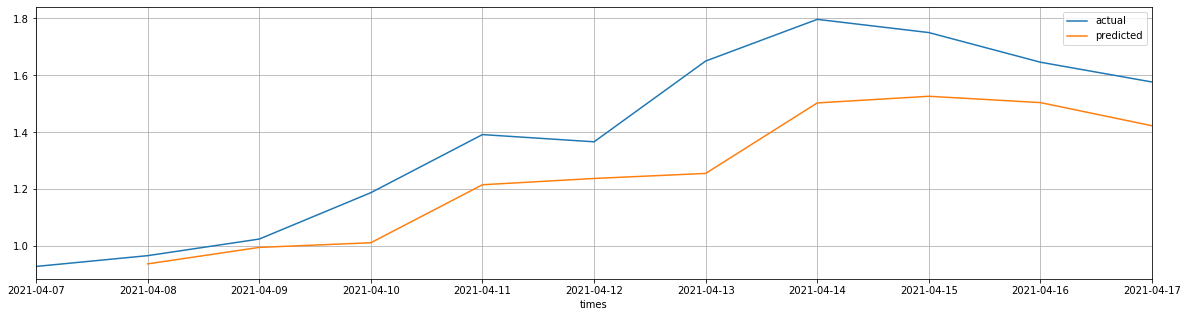

In [125]:
# aggregate to date
gt = ground_true_df.groupby(pd.to_datetime(ground_true_df.times).dt.date)[['value']].mean().reset_index()
gt.columns = ['times', 'actual']
pt = prediction_df.groupby(pd.to_datetime(prediction_df.times).dt.date)[['value']].mean().reset_index()
pt.columns = ['times', 'predicted']
allt = gt.merge(pt, on = 'times', how = 'outer')

allt.set_index('times').plot(figsize=(20,5), grid=True, label = True)

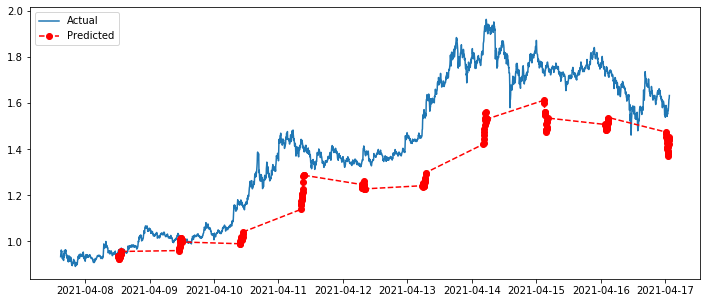

In [126]:
plt.figure(figsize=(12,5))
plt.plot(ground_true_df.times,ground_true_df.value, label = 'Actual')
plt.plot(prediction_df.times,prediction_df.value,'ro--', label='Predicted')
plt.legend(loc='upper left')
plt.show()